In [1]:
!pip insall torchvision

ERROR: unknown command "insall" - maybe you meant "install"


Running on: cuda


100%|██████████| 170M/170M [00:07<00:00, 24.2MB/s]



--- ACT I: Training VQ-VAE (Learning the Codebook) ---
VQ-VAE Epoch 1 | Loss: 1.7180
VQ-VAE Epoch 2 | Loss: 0.0631
VQ-VAE Epoch 3 | Loss: 0.0503
VQ-VAE Epoch 4 | Loss: 0.0483
VQ-VAE Epoch 5 | Loss: 0.0506
VQ-VAE Epoch 6 | Loss: 0.0531
VQ-VAE Epoch 7 | Loss: 0.0552
VQ-VAE Epoch 8 | Loss: 0.0565
VQ-VAE Epoch 9 | Loss: 0.0573
VQ-VAE Epoch 10 | Loss: 0.0577

--- ACT II: Training PixelCNN (Learning the Sequence) ---
PixelCNN Epoch 1 | Loss: 3.9586
PixelCNN Epoch 2 | Loss: 3.5256
PixelCNN Epoch 3 | Loss: 3.4547
PixelCNN Epoch 4 | Loss: 3.4107
PixelCNN Epoch 5 | Loss: 3.3753
PixelCNN Epoch 6 | Loss: 3.3465
PixelCNN Epoch 7 | Loss: 3.3214
PixelCNN Epoch 8 | Loss: 3.2979
PixelCNN Epoch 9 | Loss: 3.2767
PixelCNN Epoch 10 | Loss: 3.2543

--- ACT III: Generating New Images ---


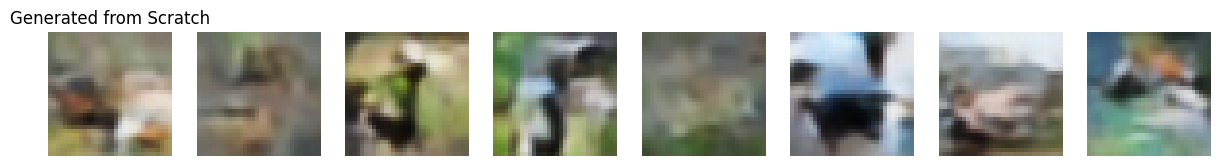

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 128
NUM_EPOCHS_VQ = 10      # Increase this for better quality (e.g., 50)
NUM_EPOCHS_PIXEL = 10   # Increase this for better quality (e.g., 50)
NUM_EMBEDDINGS = 128    # Codebook size (Number of vectors)
EMBEDDING_DIM = 64      # Vector dimension
LEARNING_RATE = 1e-3

print(f"Running on: {DEVICE}")

# ======================================================================
# PART 1: MODEL ARCHITECTURES
# ======================================================================

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # inputs shape: [Batch, Channels, Height, Width]
        input_shape = inputs.shape

        # Flatten: [Batch, Height, Width, Channels]
        flat_input = inputs.permute(0, 2, 3, 1).contiguous()
        flat_input = flat_input.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize
        quantized = torch.matmul(encodings, self._embedding.weight)
        quantized = quantized.view(input_shape[0], input_shape[2], input_shape[3], input_shape[1])
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()

        return loss, quantized, encoding_indices

class VQVAE(nn.Module):
    def __init__(self):
        super(VQVAE, self).__init__()
        # Encoder: 32x32 -> 8x8
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 64, 3, 1, 1) # Project to embedding dim
        )
        self.vq_layer = VectorQuantizer(NUM_EMBEDDINGS, EMBEDDING_DIM)
        # Decoder: 8x8 -> 32x32
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, 1, 1), nn.Tanh() # Tanh for -1 to 1 output
        )

    def forward(self, x):
        z = self.encoder(x)
        loss, quantized, _ = self.vq_layer(z)
        x_recon = self.decoder(quantized)
        return loss, x_recon

# --- PIXEL CNN (For Act II) ---
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        self.register_buffer('mask', self.weight.data.clone())
        _, _, kH, kW = self.weight.size()
        self.mask.fill_(1)
        self.mask[:, :, kH // 2, kW // 2 + (mask_type == 'B'):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

class PixelCNN(nn.Module):
    def __init__(self, num_embeddings, hidden_dim=128):
        super(PixelCNN, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, hidden_dim)
        self.layers = nn.Sequential(
            MaskedConv2d('A', hidden_dim, hidden_dim, 7, 1, 3, bias=False), nn.BatchNorm2d(hidden_dim), nn.ReLU(),
            MaskedConv2d('B', hidden_dim, hidden_dim, 7, 1, 3, bias=False), nn.BatchNorm2d(hidden_dim), nn.ReLU(),
            MaskedConv2d('B', hidden_dim, hidden_dim, 7, 1, 3, bias=False), nn.BatchNorm2d(hidden_dim), nn.ReLU(),
            MaskedConv2d('B', hidden_dim, hidden_dim, 7, 1, 3, bias=False), nn.BatchNorm2d(hidden_dim), nn.ReLU(),
            MaskedConv2d('B', hidden_dim, hidden_dim, 7, 1, 3, bias=False), nn.BatchNorm2d(hidden_dim), nn.ReLU(),
        )
        self.out = nn.Conv2d(hidden_dim, num_embeddings, 1) # Output logits for each code

    def forward(self, x):
        # x: [Batch, Height, Width] (Indices)
        x = self.embedding(x) # [Batch, Height, Width, Hidden]
        x = x.permute(0, 3, 1, 2) # [Batch, Hidden, Height, Width]
        x = self.layers(x)
        return self.out(x) # [Batch, Num_Embeddings, Height, Width]

# ======================================================================
# PART 2: DATA SETUP
# ======================================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Using CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Instantiate Models
vq_model = VQVAE().to(DEVICE)
pixelcnn_model = PixelCNN(NUM_EMBEDDINGS).to(DEVICE)

optimizer_vq = optim.Adam(vq_model.parameters(), lr=LEARNING_RATE)
optimizer_pixel = optim.Adam(pixelcnn_model.parameters(), lr=LEARNING_RATE)

# ======================================================================
# ACT I: TRAIN VQ-VAE (The Dictionary)
# ======================================================================
print("\n--- ACT I: Training VQ-VAE (Learning the Codebook) ---")

for epoch in range(NUM_EPOCHS_VQ):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(DEVICE)

        optimizer_vq.zero_grad()

        vq_loss, recon_images = vq_model(images)
        recon_loss = F.mse_loss(recon_images, images)
        loss = recon_loss + vq_loss

        loss.backward()
        optimizer_vq.step()
        total_loss += loss.item()

    print(f"VQ-VAE Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

# ======================================================================
# ACT II: TRAIN PIXELCNN (The Grammar)
# ======================================================================
print("\n--- ACT II: Training PixelCNN (Learning the Sequence) ---")
vq_model.eval() # Freeze VQ-VAE
pixelcnn_model.train()
criterion = nn.CrossEntropyLoss()

for epoch in range(NUM_EPOCHS_PIXEL):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(DEVICE)

        # 1. Get Indices from VQ-VAE (Don't train VQ-VAE)
        with torch.no_grad():
            z = vq_model.encoder(images)
            _, _, indices = vq_model.vq_layer(z)
            # Reshape flat indices to grid [Batch, 8, 8]
            indices = indices.view(images.shape[0], 8, 8)

        # 2. Train PixelCNN
        optimizer_pixel.zero_grad()

        # Output shape: [Batch, 128 (Classes), 8, 8]
        logits = pixelcnn_model(indices)

        loss = criterion(logits, indices)
        loss.backward()
        optimizer_pixel.step()
        total_loss += loss.item()

    print(f"PixelCNN Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

# ======================================================================
# ACT III: GENERATION (The Creation)
# ======================================================================
print("\n--- ACT III: Generating New Images ---")

pixelcnn_model.eval()
vq_model.eval()

num_generated = 8
# Start with a blank grid of indices [8 images, 8x8 grid]
generated_indices = torch.zeros((num_generated, 8, 8), dtype=torch.long).to(DEVICE)

with torch.no_grad():
    # Autoregressive Loop: Generate one pixel at a time
    for row in range(8):
        for col in range(8):
            # Pass current grid to PixelCNN
            logits = pixelcnn_model(generated_indices)

            # Get probabilities for the current pixel (row, col)
            probs = F.softmax(logits[:, :, row, col], dim=1)

            # Sample from the distribution (Multinomial sampling)
            # This creates variety!
            next_pixel = torch.multinomial(probs, 1).squeeze(1)

            # Update the grid
            generated_indices[:, row, col] = next_pixel

    # Decode the generated indices
    # 1. Convert Indices -> One Hot
    one_hot = F.one_hot(generated_indices.view(-1), NUM_EMBEDDINGS).float()

    # 2. Lookup Codebook
    quantized = torch.matmul(one_hot, vq_model.vq_layer._embedding.weight)

    # 3. Reshape for Decoder [Batch, Channels, Height, Width]
    quantized = quantized.view(num_generated, 8, 8, EMBEDDING_DIM).permute(0, 3, 1, 2)

    # 4. Decode
    generated_images = vq_model.decoder(quantized)

# ======================================================================
# VISUALIZATION
# ======================================================================
# Helper to un-normalize images for plotting
def show_img(img, ax):
    img = img.cpu().permute(1, 2, 0).numpy()
    img = img * 0.5 + 0.5 # Un-normalize
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')

fig, axes = plt.subplots(1, num_generated, figsize=(15, 3))
for i in range(num_generated):
    show_img(generated_images[i], axes[i])
    if i == 0: axes[i].set_title("Generated from Scratch")

plt.show()